In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import PIL
from fpdf import FPDF 
import PyPDF2
import glob

### Preloading Data

In [2]:
dir_path_A = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-A Location Data New.csv'
dir_path_C = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-C Location Data New.csv'
dir_path_D = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-D Location Data New.csv'
dir_path_E = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-E Location Data New.csv'
dir_path_F = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-F Location Data New.csv'
dir_path_G = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-G Location Data New.csv'
dir_path_H = 'C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/DH-H Location Data New.csv'

In [3]:
general_drug_lib_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/L2100 drug screening layout.xlsx"  #Path with drug list with dead plates
general_drug_library = pd.ExcelFile(general_drug_lib_path) 
drug_information = pd.read_excel(general_drug_library, 'Drug Specifics', index_col = 'name')
target_pathway_info = drug_information
target_pathway_info.drop(target_pathway_info.columns.difference(['name', 'Target', 'Pathway']), 1, inplace = True)

### Location Data Preprocessing

In [4]:
def distance(x1, x2, y1, y2):
    return (np.sqrt((x2-x1)**2 + (y2-y1)**2))

In [5]:
#Preprocessing
def read_file(dir_path):
    location_data = pd.read_csv(dir_path)           #read file
    location_data.columns = ['location']            #rename column name for ease of processing
    location_data = pd.DataFrame(location_data['location'].str.split(';', expand = True)) #separate the location data from string into respective x, y, and z values
    location_data = location_data.astype(float)     #convert all to float
    location_data.columns = ['x','y','z']           #name columns
    location_data.x = location_data['x']-min(location_data['x'])
    location_data.y = location_data['y']-min(location_data['y'])
    location_data['distance'] = (abs(location_data['x'])+abs(location_data['y'])) #Find Distance from the center of the plate to each well
    return (location_data)

In [6]:
def plate_plot(location_data):
    plt.plot(location_data['x'], location_data['y'], '.')   #Plotting all location data
    x_center=[(i*9)+2 for i in range(11)]                   #Generating Well Center Data
    y_center=[(i*9)+2.5 for i in range(8)]                  #Generating Well Center Data
    xv, yv = np.meshgrid(x_center, y_center)                #Creating Grid combination of Well Center Data
    plt.plot(xv, yv,'.')                                   #Plot Data
    plt.show()
    return (location_data)

In [7]:
def plate_categorization(location_data, center_list):
    ind_list = []                                    #Empty List to story indices 
    for index, row in location_data.iterrows():
        z = 0                                         #Current well
        f = 0
        c_x = row['x']                               #Pull First X Coordinate
        c_y = row['y']                               #Pull First Y Coordinate
        for i, j in center_list:
            well_local = distance(c_x,i,c_y,j)       #Measure distance from center
            if well_local < 4.0:
                ind_list.append(z)                   #Append only if within well
            else:
                #print(f)
                f+=1
            z += 1
    #ind_list.append(z)
    print(f)
    print("Number of Detected Imaged Colonies:", len(ind_list))
    print("Number of Colony Datapoints:", len(location_data.x))
    ind_list = np.array(ind_list)                                  
    location_data['Well Location'] = ind_list.tolist()    #Add data to location data frame
    return(location_data, ind_list)

In [8]:
def generate_centers():
    center_list = []
    x_center=[(i*9)+2 for i in range(11)]
    y_center=[(i*9)+2.5 for i in range(8)]
    num_combinations = len(x_center)*len(y_center)
    xv, yv = np.meshgrid(x_center, y_center)
    x, y = xv.shape
    for i in range(x):
        for j in range(y):
            center_list.append([xv[i][j],yv[i][j]])
    center_list = np.array(center_list)    
    print(len(center_list))
    plt.plot(center_list[:,0],center_list[:,1], '.')
    #plt.plot(center_list[4,0],center_list[4,1], '.', color = 'red')
    #plt.plot(center_list[10,0],center_list[,1], '.', color = 'red')
    plt.plot(center_list[21,0],center_list[21,1], '.', color = 'red')
    return(center_list)

88
87
Number of Detected Imaged Colonies: 473
Number of Colony Datapoints: 473


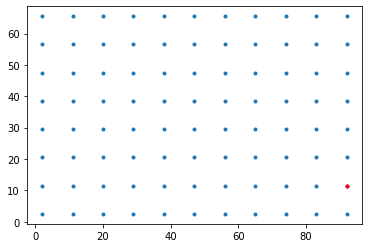

In [16]:
center_list = generate_centers()
location_data = read_file(dir_path_E)
location_data, drug_indicies = plate_categorization(location_data, center_list)

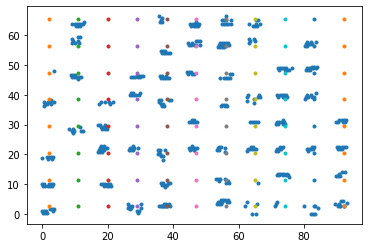

x       y        z  distance  Well Location
0    90.953   2.531  8056.32    93.484             10
1    92.253   2.531  8055.70    94.784             10
2    90.614   3.198  8054.50    93.812             10
3    89.314   3.198  8046.62    92.512             10
4    91.914   4.498  8049.30    96.412             10
..      ...     ...      ...       ...            ...
468  63.237  63.700  8000.78   126.937             84
469  65.187  63.700  7997.98   128.887             84
470  66.487  63.700  8005.30   130.187             84
471  65.838  65.000  8009.98   130.838             84
472  65.188  65.000  7991.32   130.188             84

[473 rows x 5 columns]

In [17]:
plate_plot(location_data)

In [18]:
print(drug_indicies[0])

10


### Generating Clusters

In [19]:
def find_clusters(location_data, distance):
    c_point = location_data['Well Location'][0]
    c_cluster = []
    cluster = []
    for index, row in location_data.iterrows():
        if (row['Well Location'] == c_point):
            c_cluster.append(index+1)
        else:
            cluster.append(c_cluster)
            c_cluster = [index+1]
        c_point = row['Well Location']
    cluster.append(c_cluster)
    cluster = np.array(cluster)  
    print("Number of Found Clusters:",len(cluster))
    return(cluster)

In [20]:
cluster = find_clusters(location_data, distance)

Number of Found Clusters: 58


### Checking Index for each colony

In [21]:
def return_elements(cluster, num_elem):
    ds_index = [i[:num_elem] for i in cluster]
    return (ds_index)

In [22]:
import re
num_elem = 1
ind = return_elements(cluster, num_elem)
print("Number of Clusters Found:", len(ind))
ind_new = str(ind)
ind_new= ind_new.replace('[','')
ind_new= ind_new.replace(']','')
print(ind_new)

Number of Clusters Found: 58
1, 11, 17, 20, 25, 37, 49, 60, 70, 80, 89, 97, 105, 106, 117, 123, 131, 138, 145, 153, 160, 169, 178, 186, 198, 205, 213, 222, 229, 234, 243, 251, 259, 268, 276, 282, 291, 299, 305, 314, 315, 324, 333, 341, 347, 354, 364, 375, 384, 389, 404, 414, 422, 430, 440, 445, 456, 466


In [93]:
print(location_data.iloc[120])

x                  90.351
y                  12.834
z                8053.520
distance          103.185
Well Location      21.000
Name: 120, dtype: float64


In [94]:
def plot_colony(value):
    center_list = []
    well_location = location_data['Well Location'][value]
    x_loc = location_data['x'][value]
    y_loc = location_data['y'][value]
    x_center=[(i*9)+2 for i in range(11)]
    y_center=[(i*9)+2.5 for i in range(8)]
    num_combinations = len(x_center)*len(y_center)
    xv, yv = np.meshgrid(x_center, y_center)
    x, y = xv.shape
    for i in range(x):
        for j in range(y):
            center_list.append([xv[i][j],yv[i][j]])
    center_list = np.array(center_list)    
    plt.plot(center_list[:,0],center_list[:,1], '.')
    plt.plot(center_list[well_location,0],center_list[well_location,1], '.', color = 'red')
    plt.plot(x_loc,y_loc, '.', color = 'green')
    plt.show()

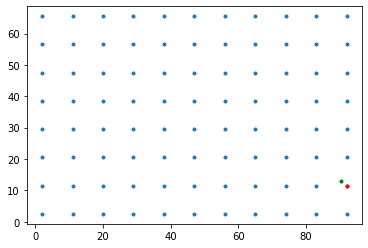

In [95]:
plot_colony(120)

### Generate Drug Labels and Extracting Pathway Information

In [96]:
drug_lib_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data)Drug Screen Location Data/Plate Layout PS.xlsx"  #Path with drug list with dead plates
drug_library = pd.ExcelFile(drug_lib_path) 
plate_str = 'E'
A_list = pd.read_excel(drug_library, plate_str)

In [97]:
def drug_list_generation(plate_list):
    col_names = [i for i in range(len(plate_list.columns))]
    row_names = plate_list.index.values
    row_names = list(row_names)
    drug_list = []
    for i in row_names:
        v = i/2
        if v%2 !=0:
            for j in range(len(col_names)):
                if plate_list.loc[i,j] != 'dead':
                    drug_list.append(plate_list.loc[i,j])
        else:
            for k in range(len(col_names)-1, -1, -1):
                if plate_list.loc[i,k] != 'dead':
                    drug_list.append(plate_list.loc[i,k])
    print("Number of Drugs:", len(drug_list))
    return (drug_list)

In [98]:
def drug_name_processing(drug_library, plate_name):
    plate = pd.read_excel(drug_library, plate_name)
    z = [2*(i+1) for i in range(int(len(plate.index)/2))]
    plate = plate.iloc[z,:]
    plate = plate.dropna(axis=1, thresh = 2)
    plate.fillna("dead", inplace = True)
    plate.columns = [i for i in range(len(plate.columns))]
    return (plate)

In [99]:
def generate_pathway_information(drug_list, target_pathway_info):
    target_info_text = []
    pathway_info_text = []
    ctrls = ['mTeSR1', 'BMP4+DMSO', 'BMP4', 'BMP4 (PBS)', 'BMP4 (DMSO)', 'BMP4(DMSO)']
    for i in drug_list:
        if i in ctrls:
            target_info_text.append('Control')
            pathway_info_text.append('Control')
        else:
            target_info_text.append(target_pathway_info.loc[i][1])
            pathway_info_text.append(target_pathway_info.loc[i][0])
    return(target_info_text, pathway_info_text)

In [100]:
drug_plate = drug_name_processing(drug_library, plate_str)
drug_plate

0           1                       2   \
2   mTeSR1     SH-4-54                   UM729   
4   mTeSR1        dead               FR 180204   
6     BMP4      K02288                 XMD8-92   
8     BMP4        dead  Vactosertib (TEW-7197)   
10    dead  AR-A014418   Decernotinib (VX-509)   
12    dead       FH535                   IM-12   
14    dead       WIKI4                    dead   
16    dead        dead                    dead   

                                     3                             4   \
2                               PI-3065  Ruboxistaurin (LY333531 HCl)   
4                                SD-208                     L-685,458   
6                            LDN-214117                    PF-4989216   
8     Cerdulatinib (PRT062070, PRT2070)                          dead   
10                  Pilaralisib (XL147)                GSK269962A HCl   
12                                 dead                       AZD8186   
14  Peficitinib (ASP015K, JNJ-54781532)                       VX-11e    
16                           Kartogenin                       Bikinin   

                                  5                             6   \
2                               dead                  8-Bromo-cAMP   
4                               dead  Dibutyryl-cAMP (Bucladesine)   
6                           BP-1-102           Isoxazole 9 (ISX-9)   
8       Smoothened Agonist (SAG) HCl                          dead   
10                              dead                     DEL-22379   
12            Itacitinib (INCB39110)              SH5-07 (SH-5-07)   
14                            AMG319                   Y-39983 HCl   
16  Ulixertinib (BVD-523, VRT752271)              KD025 (SLx-2119)   

                          7                                          8   \
2   Nemiralisib (GSK2269557)                                       dead   
4                       dead  Ripasudil (K-115) hydrochloride dihydrate   
6     Ochromycinone (STA-21)                                 GSK2636771   
8                       dead                               ZM 39923 HCl   
10                  SIS3 HCl     Nirogacestat (PF-03084014, PF-3084014)   
12                   PLX7904                                       dead   
14                      dead                                       dead   
16                      dead                                       dead   

                       9                             10  
2                    dead  Hydroxyfasudil (HA-1100) HCl  
4                    dead                          IQ-1  
6                    dead         HPI-4 (Ciliobrevin A)  
8     VO-Ohpic trihydrate                          dead  
10                   dead                         IMR-1  
12  umbralisib (TGR-1202)                 Alantolactone  
14    Oclacitinib maleate                          dead  
16                MK-4101                          dead

In [101]:
drug_list = drug_list_generation(drug_plate)
drug_list 

Number of Drugs: 58


['mTeSR1',
 'SH-4-54',
 'UM729',
 'PI-3065',
 'Ruboxistaurin (LY333531 HCl)',
 '8-Bromo-cAMP',
 'Nemiralisib (GSK2269557)',
 'Hydroxyfasudil (HA-1100) HCl',
 'IQ-1',
 'Ripasudil (K-115) hydrochloride dihydrate',
 'Dibutyryl-cAMP (Bucladesine)',
 'L-685,458',
 'SD-208',
 'FR 180204',
 'mTeSR1',
 'BMP4',
 'K02288',
 'XMD8-92',
 'LDN-214117',
 'PF-4989216',
 'BP-1-102',
 'Isoxazole 9 (ISX-9)',
 'Ochromycinone (STA-21)',
 'GSK2636771',
 'HPI-4 (Ciliobrevin A)',
 'VO-Ohpic trihydrate',
 'ZM 39923 HCl',
 'Smoothened Agonist (SAG) HCl',
 'Cerdulatinib (PRT062070, PRT2070)',
 'Vactosertib (TEW-7197)',
 'BMP4',
 'AR-A014418',
 'Decernotinib (VX-509)',
 'Pilaralisib (XL147)',
 'GSK269962A HCl',
 'DEL-22379',
 'SIS3 HCl',
 'Nirogacestat (PF-03084014, PF-3084014)',
 'IMR-1',
 'Alantolactone',
 'umbralisib (TGR-1202)',
 'PLX7904',
 'SH5-07 (SH-5-07)',
 'Itacitinib (INCB39110)',
 'AZD8186',
 'IM-12',
 'FH535',
 'WIKI4',
 'Peficitinib (ASP015K, JNJ-54781532)',
 'VX-11e ',
 'AMG319',
 'Y-39983 HCl',
 

In [102]:
target_info_text, pathway_info_text = generate_pathway_information(drug_list,target_pathway_info)

In [103]:
print(target_info_text)
print(pathway_info_text)

['Control', 'JAK/STAT', 'Metabolism', 'PI3K/Akt/mTOR', 'TGF-beta/Smad', 'Others', 'PI3K/Akt/mTOR', 'Cell Cycle', 'Stem Cells &  Wnt', 'Cell Cycle', 'Others', 'Neuronal Signaling', 'TGF-beta/Smad', 'MAPK', 'Control', 'Control', 'TGF-beta/Smad', 'MAPK', 'TGF-beta/Smad', 'PI3K/Akt/mTOR', 'JAK/STAT', 'Others', 'JAK/STAT', 'PI3K/Akt/mTOR', 'Stem Cells &  Wnt', 'Others', 'JAK/STAT', 'Stem Cells &  Wnt', 'JAK/STAT', 'TGF-beta/Smad', 'Control', 'PI3K/Akt/mTOR', 'JAK/STAT', 'PI3K/Akt/mTOR', 'Cell Cycle', 'MAPK', 'TGF-beta/Smad', 'Neuronal Signaling', 'Stem Cells &  Wnt', 'TGF-beta/Smad', 'PI3K/Akt/mTOR', 'MAPK', 'JAK/STAT', 'JAK/STAT', 'PI3K/Akt/mTOR', 'PI3K/Akt/mTOR', 'Stem Cells &  Wnt', 'Stem Cells &  Wnt', 'JAK/STAT', 'MAPK', 'PI3K/Akt/mTOR', 'Cell Cycle', 'JAK/STAT', 'Stem Cells &  Wnt', 'Cell Cycle', 'MAPK', 'PI3K/Akt/mTOR', 'TGF-beta/Smad']
['Control', 'STAT', 'AhR', 'PI3K', 'PKC', 'PKA', 'PI3K', 'ROCK', 'Wnt/beta-catenin,phosphatase', 'ROCK', 'PKA', 'Gamma-secretase', 'TGF-beta/Smad', '

### Assign Image to Drug Name and Display or Save

In [104]:
def display_colony_with_name(img_path, drug_list):
    img_paths = [(img_path + i) for i in os.listdir(img_path)]
    img_paths = sorted(img_paths, key=lambda t: os.stat(t).st_mtime)
    im_count = len(img_paths)
    if im_count != len(drug_list):
        print("Unequal number of drugs")
    else:
        print("Number of Drugs Found: ", im_count)
        for i in range(im_count):
            col_img = PIL.Image.open(img_paths[i])
            plt.imshow(col_img)
            plt.title((drug_list[i]+ "\nTarget:" + target_info_text[i] + "\nPathway:"+pathway_info_text[i]))
            plt.axis('off')
            plt.show()
        for i in range(im_count):
            print(drug_list[i])

In [109]:
def save_colonies_as_pdf(img_path, drug_list):
    img_paths = [(img_path + i) for i in os.listdir(img_path)]
    img_paths = sorted(img_paths, key=lambda t: os.stat(t).st_mtime)
    im_count = len(img_paths)
    print("Number of Drugs Found: ", im_count)
    y=1
    z=1
    for i in range(im_count):
        col_img = PIL.Image.open(img_paths[i])
        plt.imshow(col_img)
        plt.title((drug_list[i]+ "\nTarget:" + target_info_text[i] + "\nPathway:"+pathway_info_text[i]))
        plt.axis('off')
        if (drug_list[i] == 'mTeSR1'):
            plt.savefig("C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate " +plate_str+ " PDFS/"+drug_list[i]+"("+str(z)+").pdf", bbox_inches = 'tight')
            z +=1
        elif (drug_list[i] == 'BMP4'):
            plt.savefig("C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate " +plate_str+ " PDFS/"+drug_list[i]+"("+str(y)+").pdf", bbox_inches = 'tight')
            y +=1
        else:
            plt.savefig("C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate " +plate_str+ " PDFS/"+drug_list[i]+".pdf", bbox_inches = 'tight')
        plt.clf()

Number of Drugs Found:  58


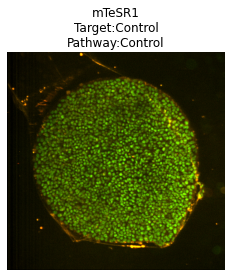

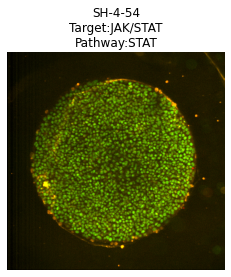

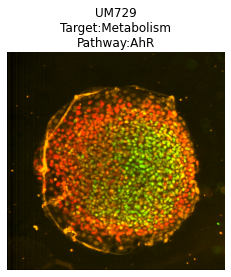

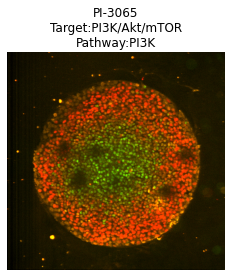

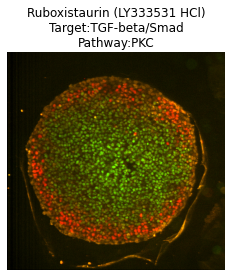

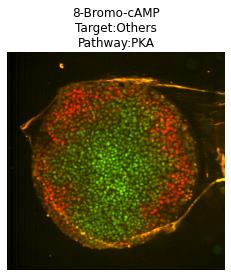

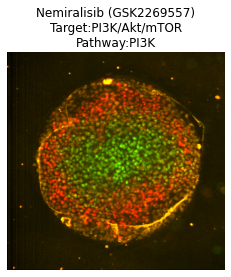

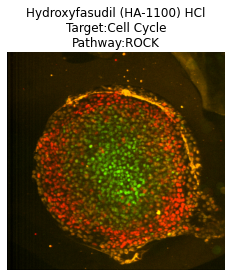

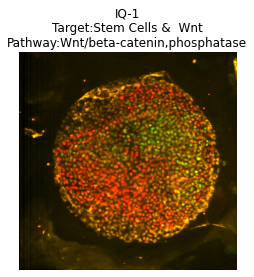

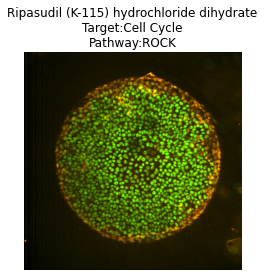

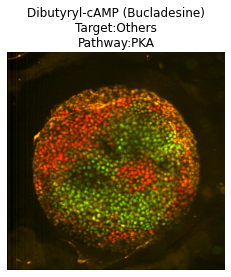

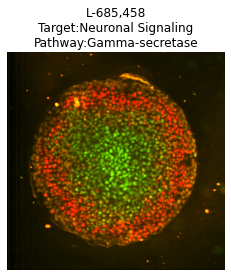

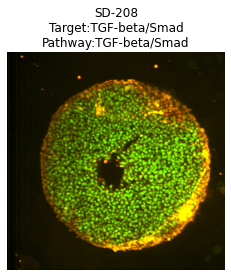

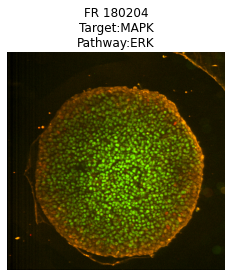

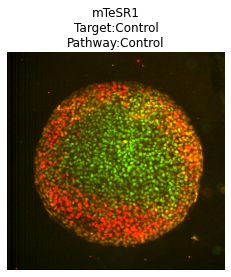

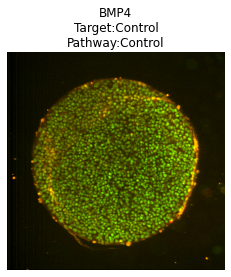

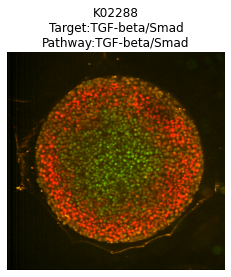

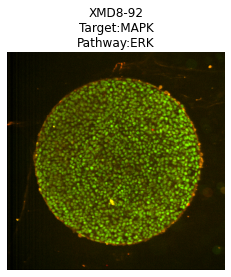

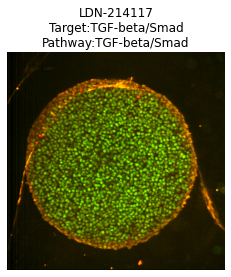

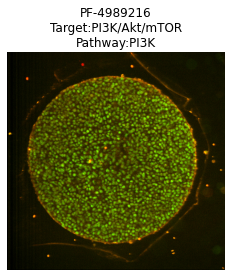

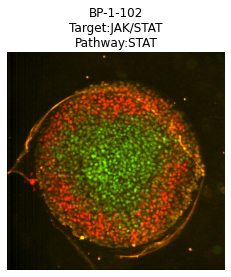

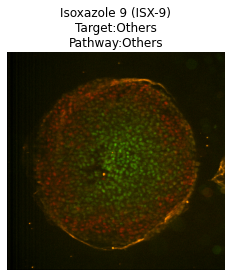

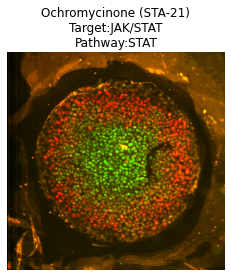

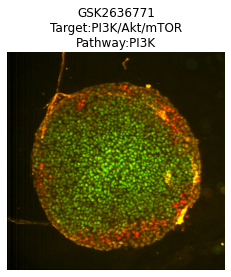

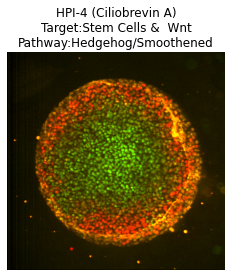

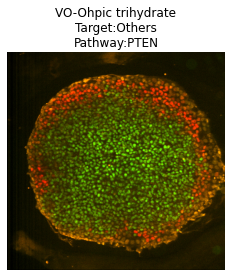

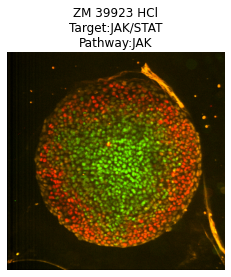

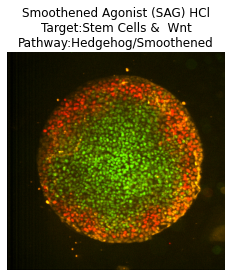

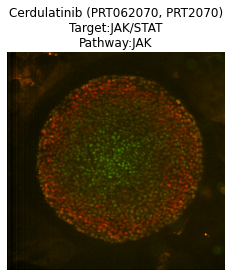

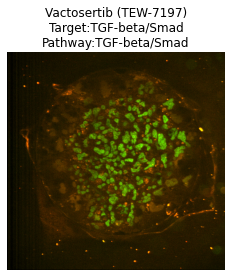

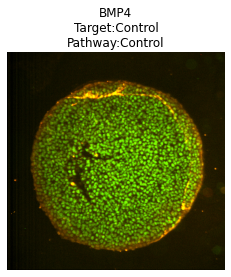

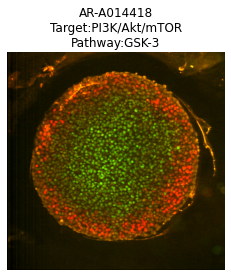

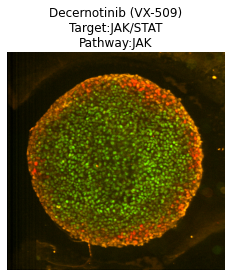

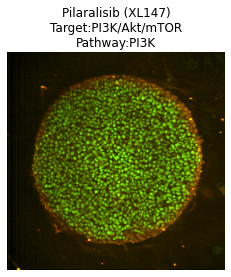

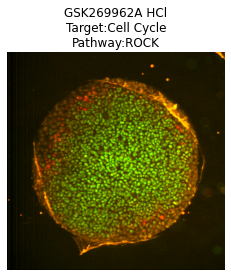

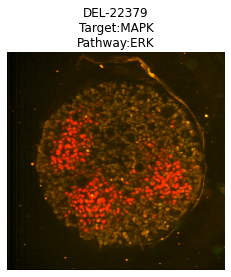

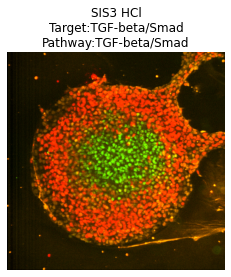

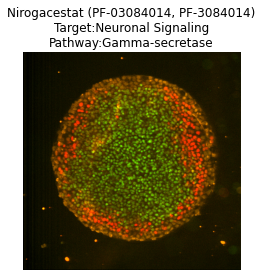

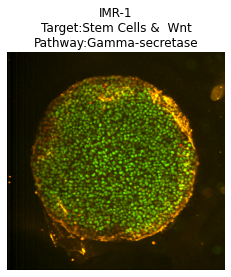

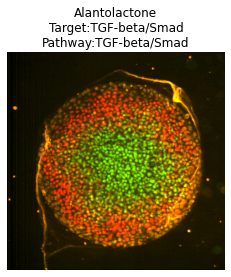

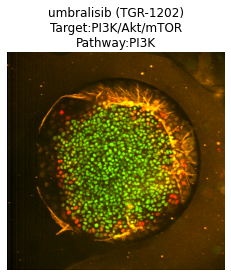

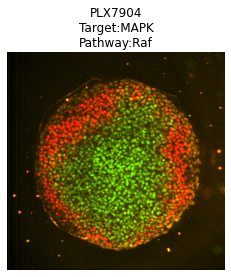

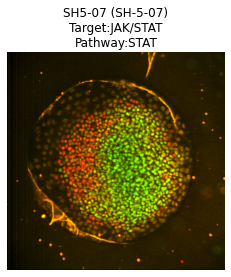

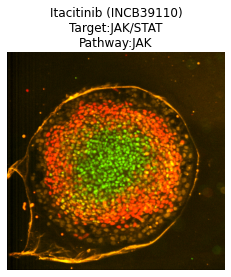

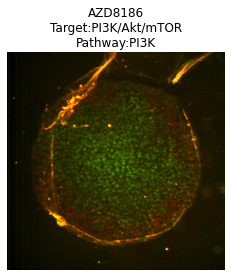

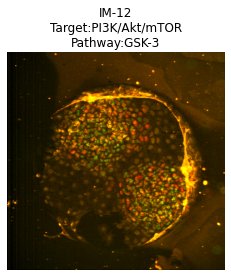

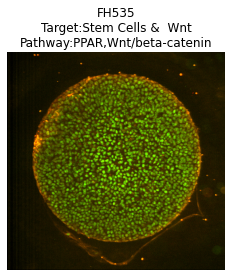

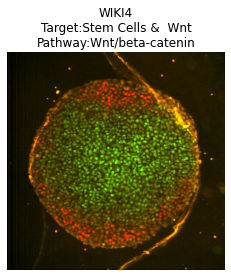

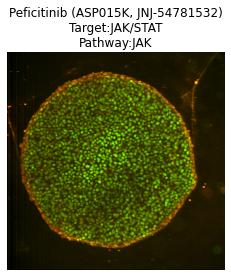

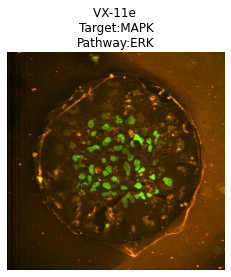

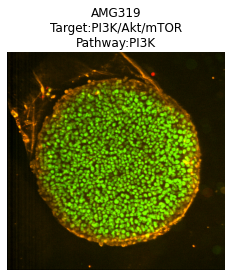

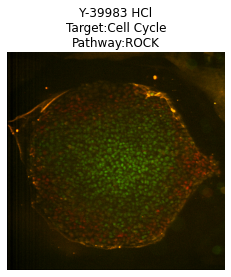

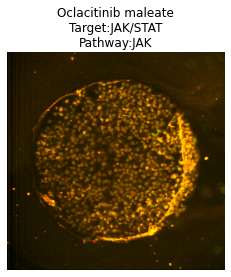

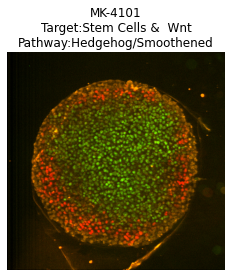

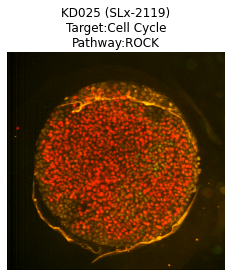

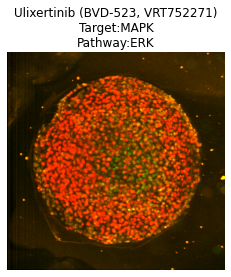

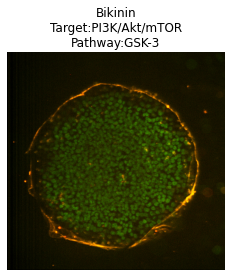

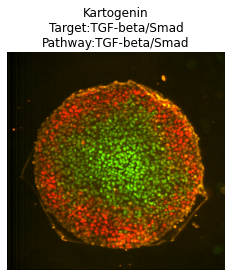

mTeSR1
SH-4-54
UM729
PI-3065
Ruboxistaurin (LY333531 HCl)
8-Bromo-cAMP
Nemiralisib (GSK2269557)
Hydroxyfasudil (HA-1100) HCl
IQ-1
Ripasudil (K-115) hydrochloride dihydrate
Dibutyryl-cAMP (Bucladesine)
L-685,458
SD-208
FR 180204
mTeSR1
BMP4
K02288
XMD8-92
LDN-214117
PF-4989216
BP-1-102
Isoxazole 9 (ISX-9)
Ochromycinone (STA-21)
GSK2636771
HPI-4 (Ciliobrevin A)
VO-Ohpic trihydrate
ZM 39923 HCl
Smoothened Agonist (SAG) HCl
Cerdulatinib (PRT062070, PRT2070)
Vactosertib (TEW-7197)
BMP4
AR-A014418
Decernotinib (VX-509)
Pilaralisib (XL147)
GSK269962A HCl
DEL-22379
SIS3 HCl
Nirogacestat (PF-03084014, PF-3084014)
IMR-1
Alantolactone
umbralisib (TGR-1202)
PLX7904
SH5-07 (SH-5-07)
Itacitinib (INCB39110)
AZD8186
IM-12
FH535
WIKI4
Peficitinib (ASP015K, JNJ-54781532)
VX-11e 
AMG319
Y-39983 HCl
Oclacitinib maleate
MK-4101
KD025 (SLx-2119)
Ulixertinib (BVD-523, VRT752271)
Bikinin
Kartogenin


In [106]:
img_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate " +plate_str+ " New/"
display_colony_with_name(img_path, drug_list)

In [107]:
img_paths = [(img_path + i) for i in os.listdir(img_path)]
img_paths = sorted(img_paths, key=lambda t: os.stat(t).st_mtime)
im_count = len(img_paths)
print(img_paths)

['C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_0.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_10.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_16.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_19.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_24.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_36.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_48.tif', 'C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate E New/(DS Main) Plate No DH-E_59.tif', 'C:/User

In [110]:
save_colonies_as_pdf(img_path, drug_list)

Number of Drugs Found:  58


<Figure size 432x288 with 0 Axes>

### Merge Imaging Data

In [111]:
def merge_pdfs(pdf_path, plate_name):
    pdf_paths = os.listdir(pdf_path)
    pdf_count = len(pdf_paths)
    pdfWriter = PyPDF2.PdfFileWriter()
    for i in range(pdf_count):
        pdfFile = open(pdf_path+pdf_paths[i], 'rb')
        print
        pdfReader = PyPDF2.PdfFileReader(pdfFile)
        pageObj = pdfReader.getPage(0)
        pdfWriter.addPage(pageObj)
    pdfOutputFile = open(plate_name+'.pdf', 'wb')
    pdfWriter.write(pdfOutputFile)

In [112]:
pdf_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Plate " + plate_str +" PDFS/" 
agg_PDF_path = "C:/Users/Chong/Documents/Work Directory(2020)/(Data) Drug Screen Imaging Data/Aggregate PDFs/"
merge_pdfs(pdf_path, agg_PDF_path+"Plate "+plate_str)